In [2]:
#https://machinelearningmastery.com/what-is-bayesian-optimization/
#https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
import matplotlib.pyplot as plt
import numpy as np
from skopt.plots import plot_gaussian_process
from skopt import gp_minimize

<font size=18>Lesson 06: Global Optimization 1</font>

This week we're going to continue our exploration of global optimization by looking at two global optimization algorithms:  Simulated Annealing and Bayesian Optimization. 


# Global Optimization

The goal of global optimization is to find the global optimimum value which means we want to identify the best possible solution in the entire search space.  However for many problems the search space is too large and/or the function landscape is too complicated to guarantee that the best solution can be found.

A metaheuristic algorithm attempts to find a good solution without any guarantee of being able to find the best solution.  Often metaheuristics are stochastic in nature, that is they incorporate randomness as an element of the search, but they aren't generally completely random in nature.  They often incorporate search patterns which are known to work well for the problem at hand.

Metaheuristic algorithms try to find a compromise somewhere between randomly searching the search space and local search.  People often speak of the **exploration and exploitation tradeoff**.  Exploration ensures the algorithm reaches different promising regions of the search space, whereas exploitation ensures the searching of optimal solutions within the given region.  The trick is in finding the right balance. Go too far into exploitation and the algorithm gets stuck in local extrema, go too far to exploration and the algorithm will waste time on solutions that are less likely to be good and ignore the information already gathered.

Unfortunately there is no single algorithm which works best for all classes of problems.  This is often referred to as a "no free lunch theorem" in optimization.  We'll focus on the two stochastic optimization algorithms that are described in your textbook:  simulated annealing and genetic algorithms.

# Simulated Annealing

Think of simulated annealing as an enhanced local search that allows some moves that don't improve the best function value to try to climb

In a hill-climbing local search we only allow moves that increase the objective function value.  

Here is our pseudo-code from the previous lesson for **Local Search:**
```
 set starting state 
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum 
             remember it 
 endwhile 
 ```

Simulated annealing is a trajectory based method for generating a sequence of solutions and is similar our basic "hill-climbing" local search algorithm.  In a strict hill-climbing algorithm we only allow uphill moves, but in simulated move we sometimes allow downhill moves and are more likely to allow downhill moves in the early part of the search.  The idea is that to find the tallest peak in a mountain range we have to first descend from a lower peak.

The probability of a downhill move is determined by a temperature parameter that decreases throughout the search.  The probability of a downhill move depends on the size of the downhill move compared to the temperature.  At high temperatures large and small downhill moves are probable, but as the temperature decreases only small downhill moves are probable so that the search performs similarly to a local search at low temperatures

In simulated annealing algorithm high temperature promotes exploration (global search) while low temperature promote exploitation (local search).  As the algorithm proceeds the temperature decreases and transitions from exploration to exploitation.

Here is pseudo-code for **Simulated Annealing:**
```
 set starting state and initial temperature
 while local_condition 
     select a move 
     if acceptable 
         do the move 
         if new optimum or random # < probability determined by temperature
             remember it
     decrease temperature
 endwhile 
 ```
 
Choosing the initial temperature and the manner in which the temperature decreases are critical to the performance of simulated annealing.  We'll start with a temperature schedule that looks like this:
$$ T = T_0 \alpha^n.$$
Where $T_0$ is the initial temperature, $0 < \alpha < 1,$ and $n$ is the number of iterations.   This is called geometric temperature decay, but many other choices are possible.  In the next section we'll demonstrate simulated annealing for the traveling salesman problem.



In the next section we present simulated annealing using our own code so that you can see how it works, but in general we'll use the `simanneal` package that will be introduced further below.

## Simulated Annealing with TSP (video)

We'll use the seven city example TSP from the textbook. Find the shortest tour (or cheapest cost) to visit all 7 cities and return to the starting city in the following graph:

<img src="./images/HillierTSP.png" width=400>

We'll store all of the intercity distances in a two dimensional list that we call distance_matrix. For cities that aren't connected we'll use the "bigM" method and introduce a distance of 100 between those pairs of cities so that those routes won't be included in the tour. Note that the picture labels the cities 1 through 7, but in Python we'll use 0 through 6.  The data is stored in the included json file.

If you want to really understand how simulated annealing worksThe following video includes a walkthrough of the code below.

In [2]:
# execute this cell for video
play_video("ds775_lesson5_simulated-anneal-tsp")

In [3]:
# import numpy as np
# import json
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style("darkgrid")

# load data (this may have to be adapted for different problems)
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
individual_size = tsp["TourSize"]

# define objective function
def tour_distance(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance

def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))

# Random Number Seed
# if you want reproducible results, then uncomment the following line
# and play with the seed value until you get a result you like. If you run 
# it again with the same value, then you'll get the same result.
# np.random.seed(123)

def simanneal_tsp(init_state, dist_mat, max_no_improve, init_temp, alpha): ###
    '''
    We use state to refer to the values of the input variable(s) for the objective function.
    For the TSP problem, the state is a tour of the cities.
    We use obj to refer to the objective function value.
    For the TSP problem, obj is the total distance of the tour.
    
    To adapt this for another minimization problem, 
    only the lines with tour_distance and sub_tour_reversal need to change 
    to give a different objective function and a different move function.
    Additional arguments to the objective function should be passed into the search function
    similar to how we passed in dist_mat abov
    '''

    curr_state = init_state
    curr_obj = tour_distance(curr_state, dist_mat)
    best_state = curr_state  ###
    best_obj = curr_obj  ###

    # stop search if no better state is found within max_no_improve iterations
    num_moves_no_improve = 0
    iterations = 0
    temp = init_temp

    # save history for plotting after optimization
    history = np.array([[iterations, curr_obj, best_obj]])  ###

    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        new_state = sub_tour_reversal(curr_state) # make a move
        new_obj = tour_distance(new_state, dist_mat)
        delta = curr_obj - new_obj ###
        prob = np.exp(min(delta, 0) / temp) ### # compute prob accept uphill move

        if new_obj < curr_obj or np.random.uniform() < prob : ### # accept if decrease or rand < prob
            curr_state = new_state
            curr_obj = new_obj
            if curr_obj < best_obj: ### # keep track of best ever
                best_state = curr_state ###
                best_obj = curr_obj ###
                num_moves_no_improve = 0 ###

        temp *= alpha ###

        history = np.vstack( (history, np.array([[iterations,curr_obj,best_obj]]) ) ) ###

    return best_state, best_obj, iterations, history

# apply the simanneal_tsp() function to our seven city problem
num_cities = len(distance_matrix)
init_tour = np.random.permutation(np.arange(num_cities))

best_tour, best_dist, iterations, history = simanneal_tsp(init_tour, distance_matrix, 200, 100, .995)
best_dist

63

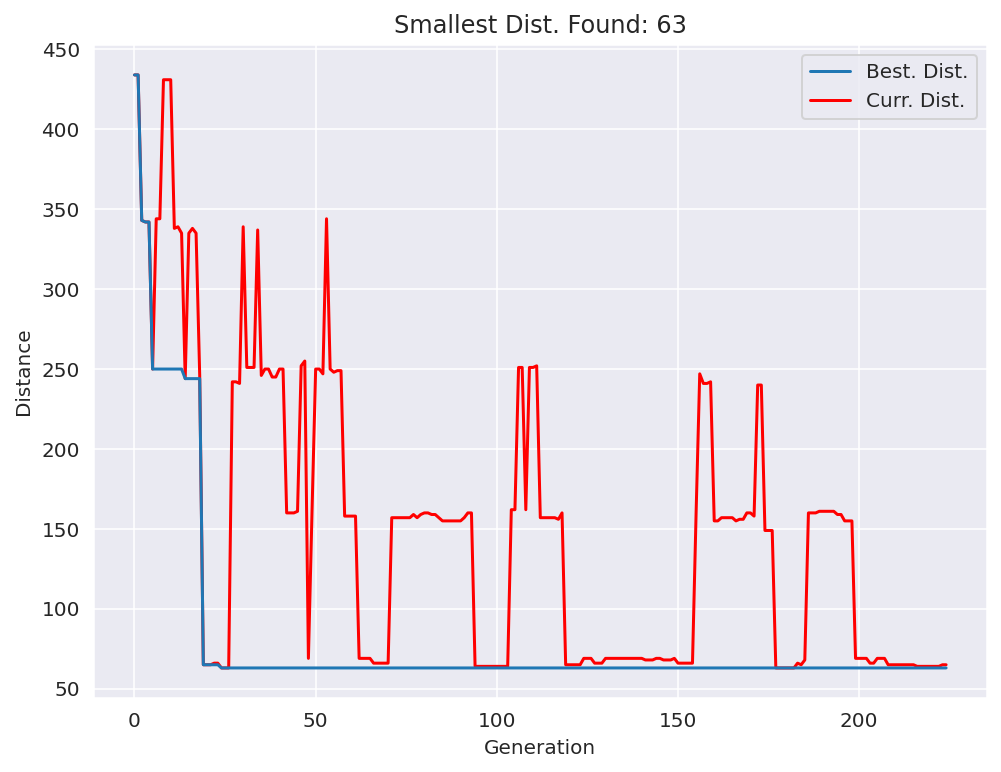

In [4]:
# plot the progress of the search for visualization
# it isn't necessary to do this in the homework, but you're welcome to do so

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], history[:,1], label='Curr. Dist.',color='red')
line_curr, = plt.plot(history[:,0],history[:,2], label='Best. Dist.')
plt.xlabel('Generation')
plt.ylabel('Distance')
plt.legend(handles=[line_curr, line_min])
plt.title('Smallest Dist. Found: {:d}'.format(int(best_dist)));

### *Self Assessment: Simulated Annealing for Gerrymandering*

Copy the gerrymandering code from Lesson 4 and adapt the simulated annealing code above to try to find a solution in which republicans win 9 of the 10 districts.  Beware that you're trying to maximize the fitness.  The simplest way to use a minimization algorithm to maximize is to negate the fitness value.  If you start with simanneal_tsp then you should need only minor changes.

You'll have to change the values of the initial temperature, max_no_improve, and alpha.  The positive initial temperature should be similar to the initial fitness values (in magnitude).  Increasing max_no_improve allows the search to explore for longer.  Increasing alpha means the temperature doesn't decrease as quickly so that more uphill moves are allowed and the algorithm can explore more of the search space.

## Using the `simanneal` package (video)

The `simanneal` package is pretty straightforward to use. Using the simanneal package has a couple of advantages over our version of simulated annealing above.  First, we don't have to worry about the algorithm framework.  Second, we don't have to worry about figuring out a temperature schedule.  While it's possible to specify a temperature schedule, it is far easier to use the `auto` scheduler and specify the approximate amount of time we'd like to wait for a solution

The package works by making an object of the Annealer class and then calling the anneal method on that object. To set up a problem we have to set three things in our instance of the Annealer class.

1.  the state initializer 
2.  the move function that tells the anneal how to generate new moves
3.  the fitness function (fitness is called energy in this package and it was called objective in the locsearch package in Lesson 4).

The anneal method appears to always find minima so you may have to negate your function if you want to find a maximum. The <a href="https://github.com/perrygeo/simanneal">Github page</a> has some short documentation about the simanneal package.

The next cell is walkthrough of the code below.

In [5]:
# execute this cell for video
play_video("ds775_lesson5_simanneal-package-on-tsp")

In [2]:
# relies on data loaded in previous section

# import numpy as np
# from simanneal import Annealer

def tour_distance(tour, dist_mat):
    distance = dist_mat[tour[-1]][tour[0]]
    for gene1, gene2 in zip(tour[0:-1], tour[1:]):
        distance += dist_mat[gene1][gene2]
    return distance

def sub_tour_reversal(tour):
    # reverse a random tour segment
    num_cities = len(tour)
    i, j = np.sort(np.random.choice(num_cities, 2, replace=False))
    return np.concatenate((tour[0:i], tour[j:-num_cities + i - 1:-1],
                              tour[j + 1:num_cities]))
class TravellingSalesmanProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, distance_matrix):
        self.distance_matrix = distance_matrix
        super(TravellingSalesmanProblem, self).__init__(state)  # important!

    def move(self):
        self.state = sub_tour_reversal(self.state)

    def energy(self):
        return tour_distance(self.state, self.distance_matrix)

# load data (this may have to be adapted for different problems)
with open("data/HillierTSP.json", "r") as tsp_data:
    tsp = json.load(tsp_data)
distance_matrix = tsp["DistanceMatrix"]
init_tour = np.random.permutation(np.arange(len(distance_matrix))).astype(int).tolist()

tsp = TravellingSalesmanProblem(init_tour, distance_matrix)
tsp.set_schedule(tsp.auto(minutes=.2)) #set approximate time to find results

best_tour, best_dist = tsp.anneal()

best_dist

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


63

### *Self Assessment: Simulated Annealing for Gerrymandering with `simanneal`*

Use the `simanneal` package to try to find a solution in which republicans win 9 of the 10 districts.  Beware that you're trying to maximize the fitness so you'll either need to use a negated fitness function.  You'll also have to set the cities data frame in the initializer (similar to the distance matrix in the tsp above).  The set up here is very similar to using the `locsearch` package to solve the gerrymandering problem as we did in the last self-assessment in Lesson 4.

If you're using the auto option for the temperature schedule then it could take several minutes to complete a run because the search space for this problem is huge.  Each entry in the 18 dimensional vector can be a number 0 through 9 so there are $10^{18}$ possible vectors to explore.  Alternately you can manually set the temperature schedule with something like this:

```
tsp.Tmax = 5000
tsp.Tmin = 2.5
tsp.steps = 5000
tsp.updates = 100
```

You should replace tsp with the appropriate name that you setup in your code and also experiment with the numbers.  Make sure to comment out the auto schedule.  

## Simulated Annealing for Continuous Optimization

Simulated annealing was designed for combinatorial (discrete) optimization problems, but has been adapted to continuous optimization problems.  The main issue is how to generate a new move at each iteration.  There are many variations, but often the move is selected at random from a suitable probability distribution such as a normal or uniform distribution.

The objective functions we consider here aren't from real applications, instead they're chosen to give you an idea how the algorithm works for difficult optimization problems with many local optima.  It's good to have this sort of thing in mind when, for instance, you're trying to train a complicated neural network and have to optimize the weights in the network to find the best fit to your data.

### A non-convex 2D example

We found this two-dimensional example in <a href="http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing">this tutorial</a> on simulated annealing.

Find the minimum value of 
$$f(x,y) = 0.2 + x^2 + y^2 - 0.1 \cos(6 \pi x) - 0.1 \cos(6 \pi y)$$ 

for $-1 \leq x,y \leq 1$.  This function is similar to the Rastrigin function and the global minimum value is $f(0,0) = 0$.  A contour plot, shown below, illustrates that there are many local minima (in the center of many of the small loops, some correspond to local maxima).  The <a href = "http://apmonitor.com/me575/index.php/Main/SimulatedAnnealing">tutorial</a> itself is worthy of a look and has a nice flow chart outlining how simulated annealing works.

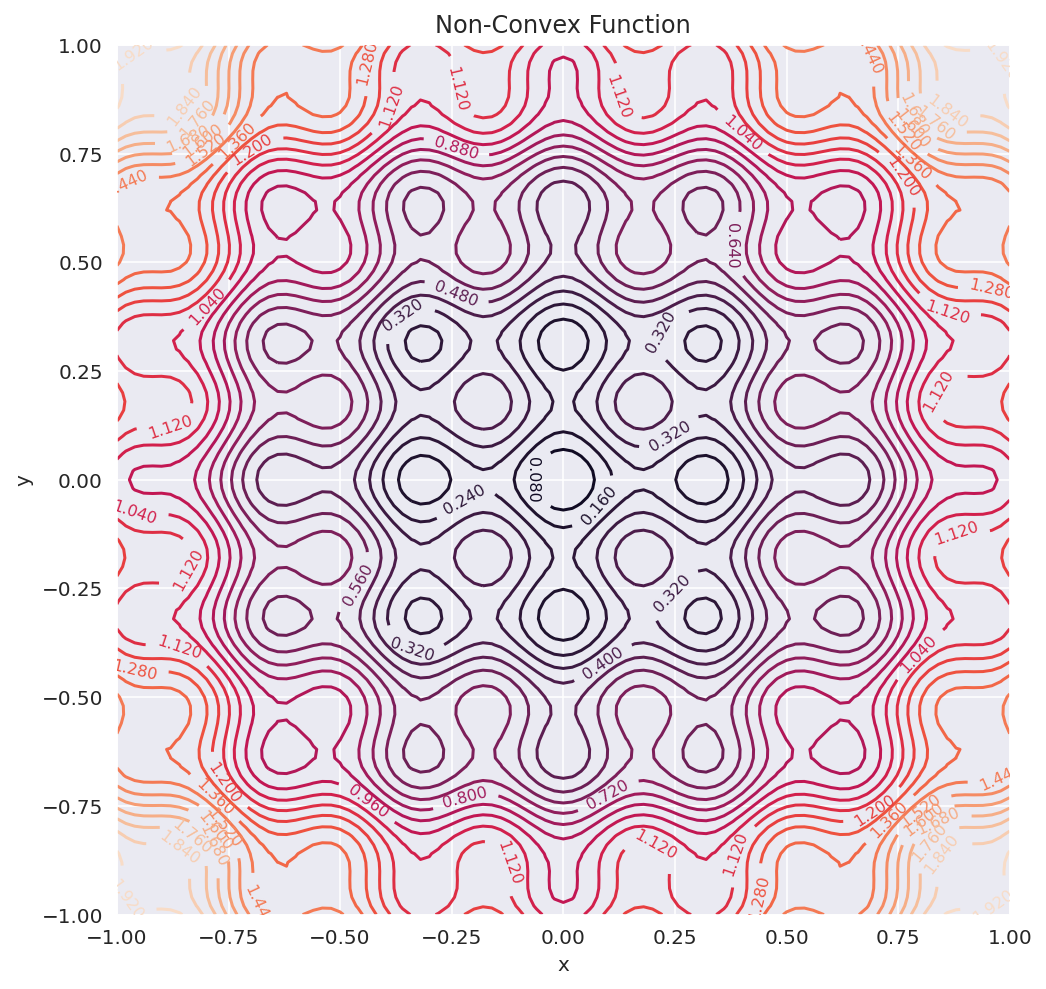

In [7]:
# define objective function and show a contour plot

def f(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj

# we could have written the objective function like this for transparency:
# if the argument is a list with [ numpy array of x's, numpy array of y's]
# def f(xy):
#     x = xy[0]
#     y = xy[1]
#     obj = 0.2 + x**2 + y**2 - 0.1*np.cos(6*np.pi*x) - 0.1*np.cos(6*np.pi*y)
#     return obj

# see script for details of plot
%run scripts/bumpy_contours.py

Here is a 3D plot that makes it easier to see all of the local minima in the search space.  A local search will easily get stuck in the wrong minimum if the initial search point isn't very close to the origin.

In [8]:
%run scripts/bumpy_2d.py

To use simulated annealing to optimize a function with continuous variables isn't all that different than how we used it to find a good, or even optimal, tour in the traveling salesman problem.  

We're going to rely on the `simanneal package` in the rest of this lesson because it's much more robust than our "homebrewed" code in the `simanneal_tsp()` function above. 
To use the package we'll have to generate an initial state, define the `energy()` method for returning the objective function value, and define the `move()` method for making a move from a current state to a new state.

To generate an initial state you could select uniformly distributed random numbers between -1 and 1:
```
init_state = np.random.uniform(low=-1, high=1, size=2)
```

We like to write functions for computing the objective function value and for making moves and then call those functions from the `move()` and `energy()` methods in the class definition for our problem as we did in the simanneal package TSP example above.

We already have the objective function from where we made the contour plot:
```
def f(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj
```

Making a move will consist of applying two functions successively.  The first function adds normally distributed random numbers to each variable while the second function clips values that are out of the $[-1,1]$ bounds.  The scale of the move will need to be passed to the first function, while the values of the lower and upper bounds need to be passed to the clipping function.  These values will need to be initialized in the `__init__` constructor similar to how we worked with the distance matrix in the TSP example.  Here are the functions:
```
def gauss_move(xy,sigma):
    # xy is a 1 by dim numpy array
    # sigma is the standard deviation for the normal distribution
    dim = len(xy)
    return xy + np.random.normal(loc = 0, scale = sigma, size=dim)

def clip_to_bounds(xy,low,high):
    # xy is a 1 by dim numpy array
    # low is the lower bound for clipping variables
    # high is the upper bound for clipping variables
    return np.array( [min(high,max(low,v)) for v in xy])
```

#### *Self-Assessment for Simulated Annealing with Continuous Variables*

Use the objective and move functions from above to create a class using the `simanneal` package.  Use it to approximate the location of the global minimum for the "Bumpy" function above.  You'll notice that you usually will get close to the location of the global minimum at the origin, but it won't be exact because it is very difficult to randomly move exactly to the minimum location.  Usually, for continuous functions simulated annealing is combined with local search in an iterative procedure (we'll see an example of this in the homework with the `dual_annealing` optimizer from the `scipy.optimize` package.  For this example you could take the best state found by simulated annealing and use it to start a local search using `minimize` from `scipy.optimize` package.

The code from the TSP example above is a good starting point.  Instead of the distance matrix you'll need to pass the scale parameter sigma to determine the size of the moves.  A good starting point for sigma is range/6 where range = upper bound - lower bound.  This value for sigma is because a normal distribution is about 6 * sigma wide.  You may want to experiment with the value of sigma to see how it effects the result of simulated annealing.  You could also play with the time allowed when you set the schedule for the annealing.

In [28]:
# Baye's optimization testing



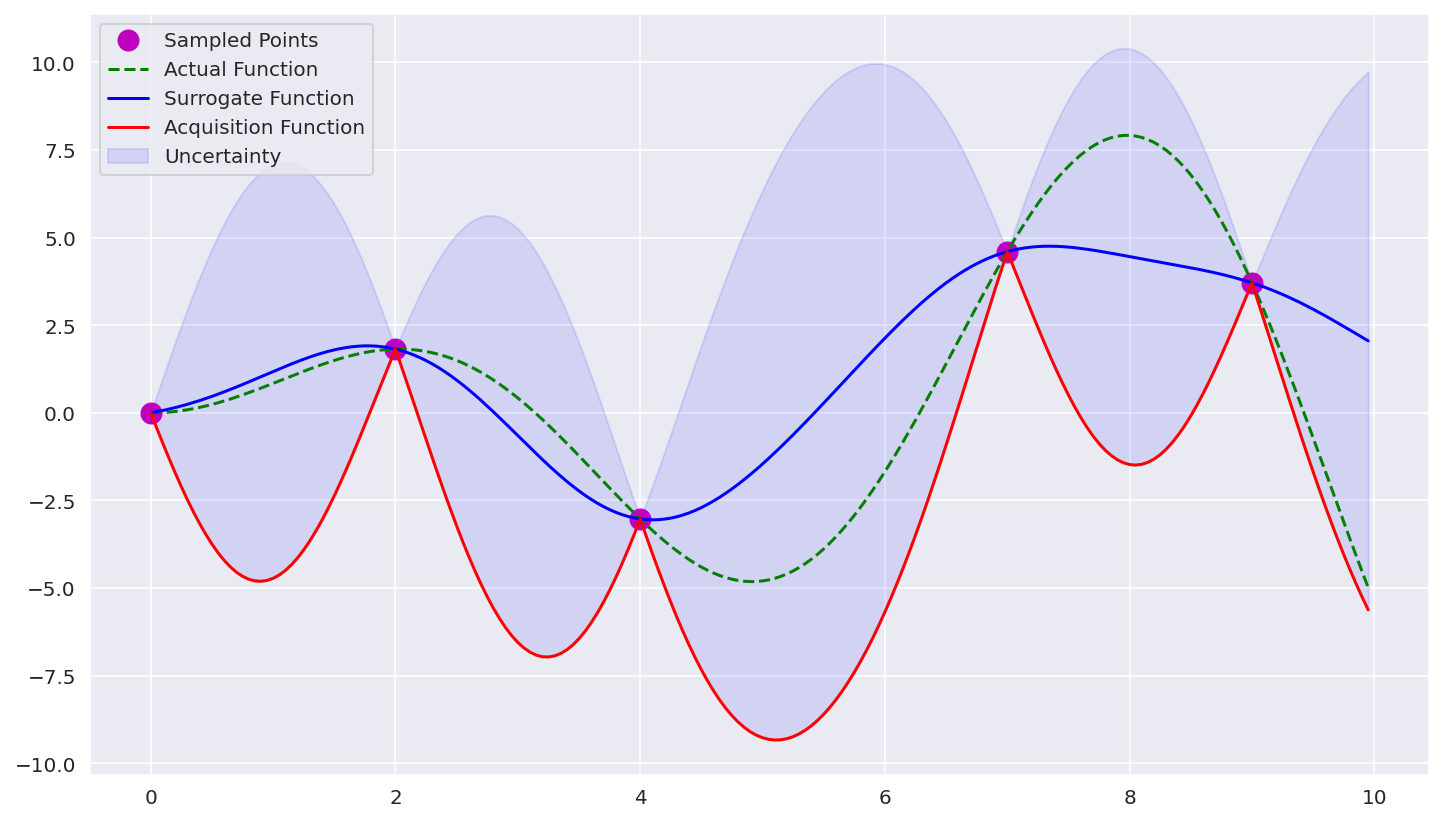

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from warnings import catch_warnings
from warnings import simplefilter
from scipy.optimize import minimize_scalar

import numpy as np

def objective(x, noise_level = 0.0 ):
    y = x * np.sin(x) + np.random.normal(loc=0,scale=noise_level)
    return(float(y))


X = np.array([0,2,4,7,9]).reshape(-1,1)
y = np.asarray([objective(x) for x in X])

# define the model
model = GaussianProcessRegressor()
model.fit(X,y)

# surrogate or approximation for the objective function
def surrogate(X, model):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)
    
def acquisition_fun_lcb(X, model, kappa):
    x2 = np.array(X).reshape(-1,1)
    y,sd = surrogate(x2, model)
    y = y.reshape(-1,1)
    sd = sd.reshape(-1,1)
    out = (y-kappa*sd).flatten()
    return( out )

def acquire_next_point(model, kappa):
    # this approach works only for one-dimensional function
    result = minimize_scalar(acquisition_fun_lcb, bounds=[0,10],method='bounded',args = (model, kappa) )
    return result.x[0]

def plot_bayesian_opt(X,y,model,objective, noise = 0, kappa = 1):
    X_plot = np.arange(0,10,.05).reshape(-1,1)
    y_obj = np.asarray([objective(x, noise_level = noise) for x in X_plot])
    y_surrogate, sd = surrogate(X_plot, model)
    y_surrogate = y_surrogate.reshape(-1,1)
    sd = sd.reshape(-1,1)
    plt.plot(X,y,'m.',markersize=20,linestyle='',label='Sampled Points')
    plt.plot(X_plot, y_obj,'g--',label='Actual Function')
    plt.plot(X_plot, y_surrogate,'b',label='Surrogate Function')
    plt.plot(X_plot, y_surrogate-kappa*sd,'r',label='Acquisition Function')
    plt.fill_between(X_plot.flatten(),(y_surrogate+kappa*sd).flatten(),(y_surrogate-kappa*sd).flatten(),color='blue',alpha=0.1,label='Uncertainty')
    
plot_bayesian_opt(X,y,model,objective,kappa = 10)
plt.legend()

In [86]:
acquire_next_point(model,10)

5.116097402702392

In [6]:
from skopt import gp_minimize

# objective function
def objective1(x, noise_level = 0.0 ):
    y = x * np.sin(x) + noise_level * np.random.randn()
    return(float(y))


np.random.seed(42) #adding random seed here, too, for the noise factor
#call the optimization.
res = gp_minimize(objective1,                  # the function to minimize
                  [(0.0,10.0)],      # the bounds on each dimension of x
                 # acq_func="PI",      # the acquisition function - using PI like above
                  n_calls=15,         # the number of evaluations of the objective function
                  n_random_starts=5,  # the number of random initialization points
                  random_state=42)   # the random seed

"x=%.4f, f(x)=%.4f" % (res.x[0], res.fun)


'x=4.9138, f(x)=-4.8145'

## Bayesian Optimization

Bayesian Optimization is becoming quite popular in the machine learning world. The big advantage of Bayesian Optimization is that it learns as it goes, and does so more efficiently that just repeatedly solving whatever your objective function is. It does this by using a surrogate function that's generally less expensive to evaluate than the objective function is, and using the results of that surrogate function to update the sample data and zero in on the optimal solution.

### Steps in Bayesian Optimization

#### Define your Objective Function

The first step in any optimization problem is determining your objective function. Bayesian optimization requires an objective function in which your variables have bounds (a finite limit on each real or integer number or a defined set of values for categorical variables). We'll use the following simple maximization problem that with a bounds of [0,1] has a global optimum of .9. 



$$f(\mathbf{x})=x^2 \sin(5 * \pi * x)^6$$

The domain is restricted so that each $x_i \in [0,1].$   


For the purposes of walking through how Bayesian Optimization works, we'll define an objective function that takes in a single-dimension x and some amount of noise. (You wouldn't need or want noise in the real world, but since we're using this as a demonstration, we want to be able to provide a "noisy" or "not perfect" view of the data.)

Let's look at the objective function and a sampling of noisy points around the objective function. The noisy points would be our sample data for which we're trying to find a global optimum.

Optima: x=0.900, y=0.810


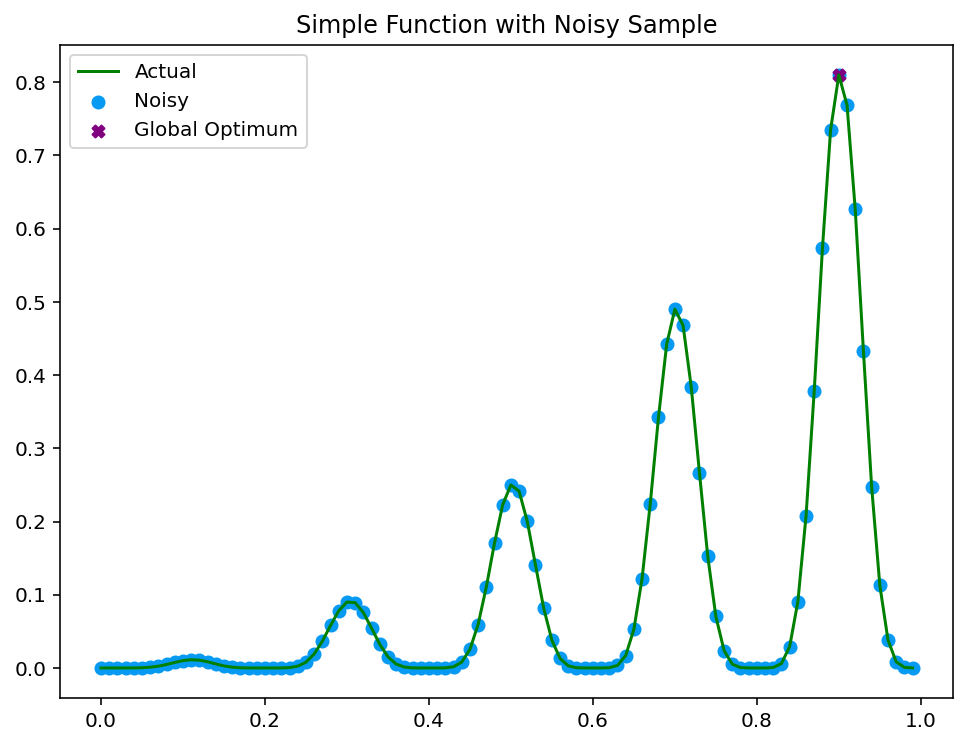

In [3]:
np.random.seed(7)
noise_level = 0

# objective function
def objective(x, noise=noise_level):
    return (x**2 * np.sin(5 * np.pi * x)**6.0) + (np.random.normal(loc=0, scale=noise_level) * noise)


# grid-based sample of the domain [0,1]
X = np.arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
# sample the domain with noise
ynoise = [objective(x) for x in X]
# find best result
ix = np.argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

plt.rcParams["figure.figsize"] = (8,6)
# plot the points with noise
plt.scatter(X, ynoise, c='#069AF3', label="Noisy");
plt.scatter(.9,.81, color="purple", marker='X', label="Global Optimum")
# plot the points without noise
plt.plot(X, y, c="green", label="Actual");
plt.title('Simple Function with Noisy Sample');
plt.legend();
# show the plot
plt.show();

Note that if you change the numpy random seed, the green line (the actual function line) would not change. But the blue dots (the noisy data) would change. Feel free to change the seed and rerun the code to see that in action.

**Our job would be, given the noisy blue dots, find the global maximum of the green line (.9,.81).**

#### Define you Surrogate Function
With a function as simple as this function, we could simply just run the function from random starting points multiple times, looking for improvement - as we've seen before in hill-climbing. But imagine if your function was a 10-fold cross-validation of a machine learning algorithm with 10 hyperparameters that could each take on 5-10 values. It could take days to evaluate that over and over again, and we're not actually learning from our previous iterations.

Enter the surrogate function. The surrogate function is a function that's less computationally expensive to evaluate, that helps the algorithm get closer to the optimum solution. It does this by summarizing the conditional probability of the objective function (f), given the available data (D). In other words, it determines the P(f|D).

There are several common surrogate functions you might see when Bayesian Optimization is implemented. Perhaps the most common is a Gaussian predictive model. A Gaussian model assumes that your parameters follow a normal distribution, even if the exact mean and standard variation are unknown. It's computationally quick to evaluate. And, thanks to scikit-learn, it's easy to implement in code. 

We'll use the default parameters for the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html">GaussianProcessRegressor</a> for our surrogate function. This function can issue warnings if we don't have a lot of data at a particular part of the distribution we're sampling, so we'll write a wrapper function to supress the warnings, and we'll return the standard deviation, which we'll use in the next step.

Like all predictive models, this model needs to be trained. We'll get to that shortly. For now, let's just define our surrogate function.

In [4]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        #return the predictions
        return model.predict(X, return_std=True)

Let's take a look at what our surrogate function returns, before we do any optimization of results. We're writing a helper function for plotting here. It takes in our X and y values, the surrogate model, and title we want displayed, and the location of our global optimum (since we know it). Then, we'll fit our model to some random data and plot it against our surrogate function.

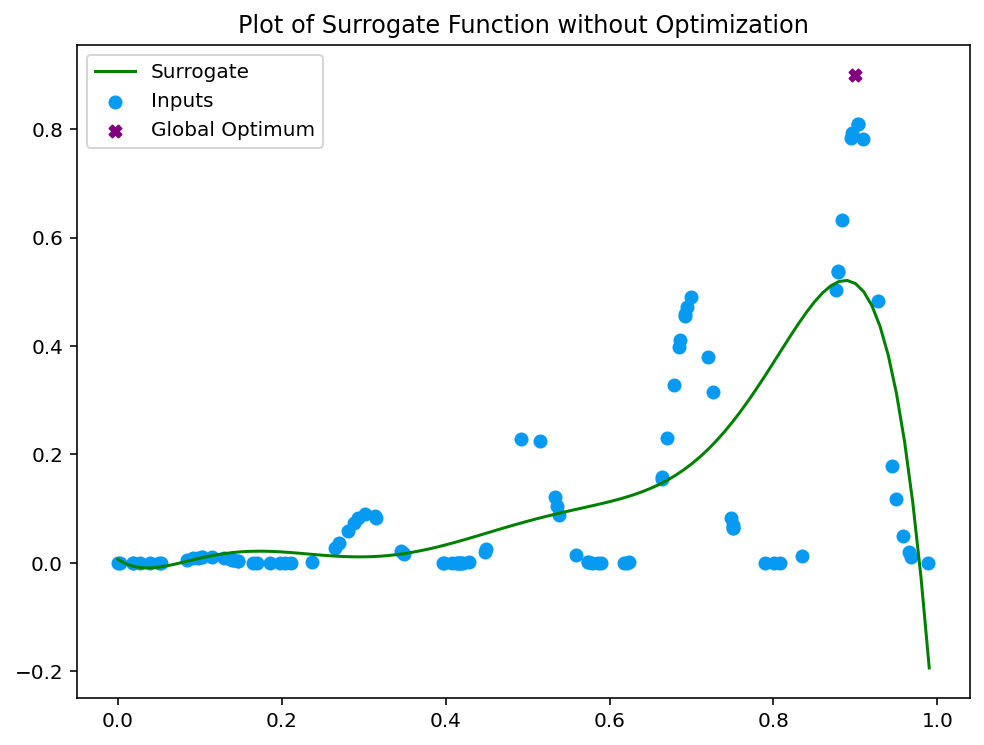

In [5]:
def objective(x, noise=noise_level):
    return (x**2 * np.sin(5 * np.pi * x)**6.0) + (np.random.normal(loc=0, scale=noise_level) * noise)

# plot helper
def plot(X, y, model, title, global_opt = [.9, .9]):
    # scatter plot of inputs and real objective function
    plt.scatter(X, y, c='#069AF3', label="Inputs")
    # line plot of surrogate function across domain
    Xsamples = np.arange(0, 1, 0.01).reshape(-1,1)
    ysamples, _ = surrogate(model, Xsamples)
    plt.plot(Xsamples, ysamples, c="green", label="Surrogate")
    plt.scatter(global_opt[0], global_opt[1], color="purple", marker='X', label="Global Optimum")
    plt.title(title)
    plt.legend()
    # show the plot
    plt.show()
    
np.random.seed(1)
sampleSize = 100
low = 0
high = 1
# sample the domain sparsely with noise
X = np.random.uniform(low, high, sampleSize).reshape(-1,1)
y = np.asarray([objective(x) for x in X]).reshape(-1,1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model, 'Plot of Surrogate Function without Optimization')    

/home/user/.local/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


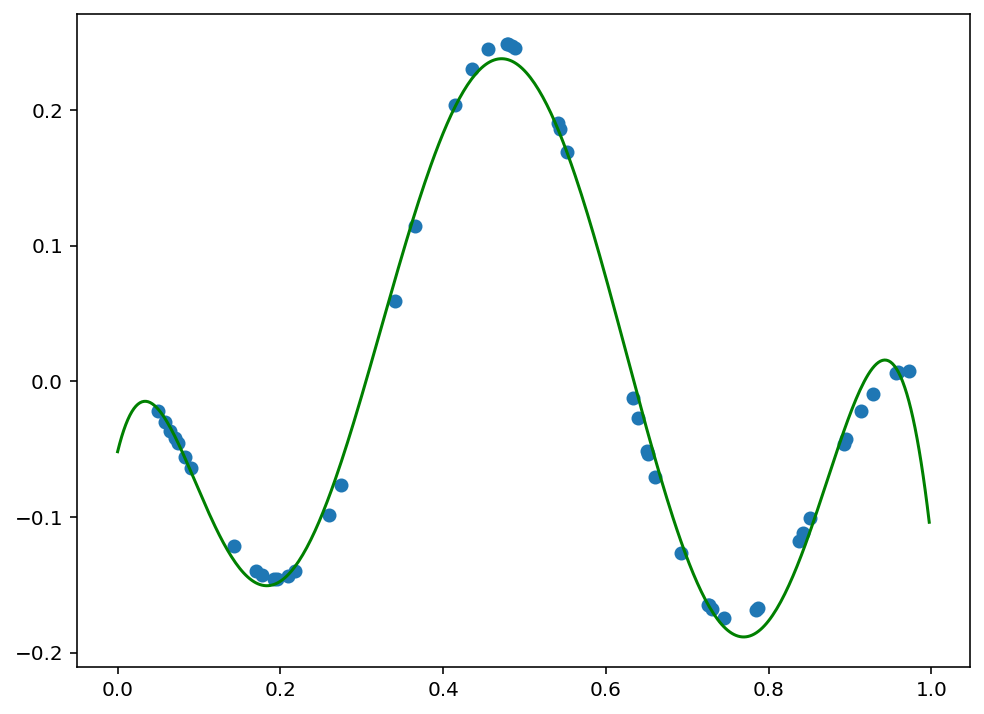

In [55]:
noise_level = 0

def objective(x, noise=noise_level):
#    return (x**2 * np.sin(5 * np.pi * x)**6.0) + (np.random.normal(loc=0, scale=noise_level) * noise)
    return((x**2-x) * np.sin(10*x))

#np.random.seed(3)
sampleSize = 50
low = 0
high = 1
# sample the domain sparsely with noise
X = np.random.uniform(low, high, sampleSize).reshape(-1,1)
y = np.asarray([objective(x) for x in X]).reshape(-1,1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
#plot(X, y, model, 'Plot of Surrogate Function without Optimization')
plt.scatter(X,y)

Xsamples = np.arange(0,1,.0025).reshape(-1,1)
#Xsamples = X
ysample,_  = model.predict(Xsamples,return_std=True)
#ysample,_ = surrogate(model,Xsamples)
plt.plot(Xsamples,ysample,color='green')

#### Define an Acquisition Function
Next we need what's called an acquisition function. Remember we said that Bayes Optimization learns as it goes. It does that by "acquiring" new data points. Each iteration of the algorithm will run the surrogate model and then "acquire" the sample point or points that are most likely to improve the overall results. Again, there are many ways to do approach determining what the best new points are. Three common approaches are:

* Probability of Improvement (PI).
* Expected Improvement (EI).
* Lower Confidence Bound (LCB).

The probability of improvement is the simplest approach, so we'll use that for demonstration purposes. The formula is

$PI = cdf((mu-best\_mu)/stdev)$

Where $cdf$ is the normal cumulative distribution function (available in <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html">sklearn</a>), $mu$ is the mean of the surrogate function for the given sample x, $stdev$ is the standard deviation of the surrogate function for the given sample x (which we can get as a returned value from our Gaussian model) and $best\_mu$ is the mean of the surrogate function for the best sample found so far. 

We can add a very small number to the standard deviation to avoid a divide by zero error. Let's look at our acquisition function and our function to optimize our acquisition value. Finally, we'll return the value with the best probability of improvement.



In [6]:
# optimize the acquisition function
def acquisition(X, y, model, low, high, size, verbose=False):
    # random search, generate random samples
    Xsamples = np.random.uniform(low, high, size)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # calculate the probability of improvement
    scores = norm.cdf((mu-best) / (std+1E-9))
    # locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix, 0]


#### Define your Iterator Function
Finally, just like in previous algorithms, we'll repeat a series of steps over and over, trying to narrow in on the best solution. Here we'll call our iteration function bayes_opt. It takes in the parameters needed to run each of our internal functions as well as the number of outer and inner iterations we want to run. For each outer iteration, we'll be evaluating our true objective function. For each inner iteration, we'll be evaulating our surrogate function.

It returns the best X and y values.

In [7]:
def bayes_opt(outer_iters, inner_iters, size, X, y, model, low, high, verbose=False):
    # perform the optimization process
    for i in range(outer_iters):
        #track the inner_iters best points using the acquisition model to determine where to sample next
        next_points = []
        for j in range(inner_iters):           
            next_points.append(acquisition(X, y, model, low, high, size, verbose))
        x = next_points[np.argmax(np.array(next_points))]  
        # sample the point
        actual = objective(x)       
        if verbose:
            # summarize the finding
            est, _ = surrogate(model, [[x]])
            print('x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
        
        # add the data to the dataset
        X = np.vstack((X, [[x]]))
        y = np.vstack((y, [[actual]]))
        # update the model
        model.fit(X, y)
    return X, y    


#### Putting it all Together

Let's put all of our code in one cell and run our optimization algorithm.

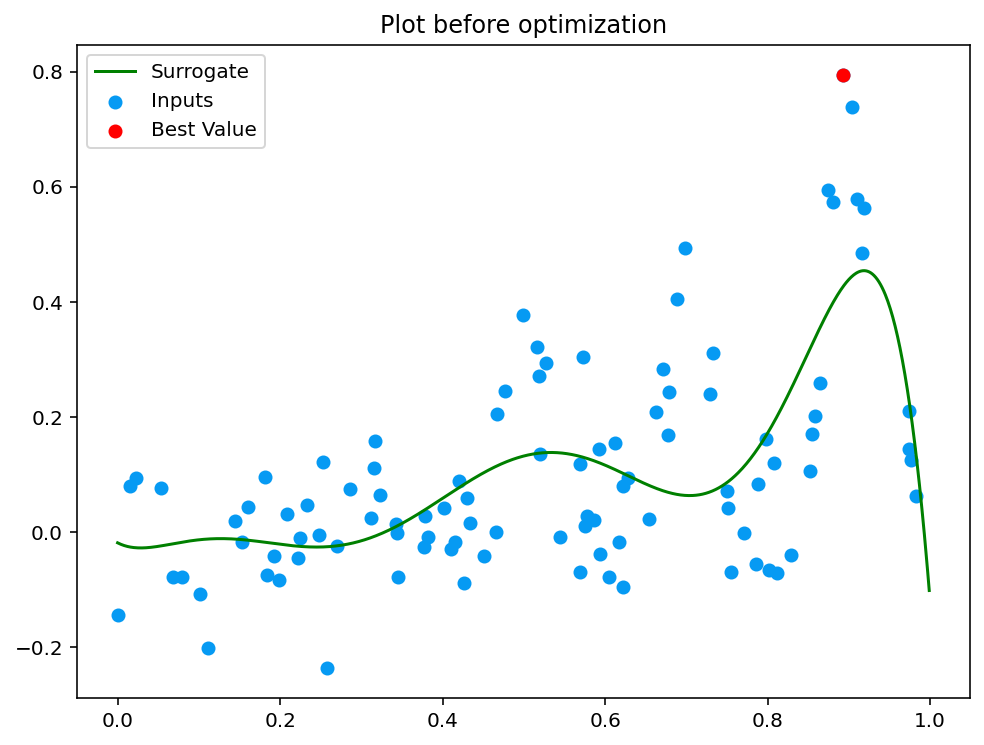

Best Result: x=0.893, y=0.794


x=0.937, f()=0.435872, actual=0.354


x=0.941, f()=0.416605, actual=0.328


x=0.947, f()=0.389682, actual=0.284


x=0.945, f()=0.387265, actual=0.250


x=0.928, f()=0.415654, actual=0.591


x=0.946, f()=0.381863, actual=0.059


x=0.931, f()=0.402671, actual=0.456


x=0.933, f()=0.403041, actual=0.454


x=0.930, f()=0.410597, actual=0.356


x=0.934, f()=0.401446, actual=0.181


x=0.935, f()=0.385715, actual=0.488


x=0.941, f()=0.377003, actual=0.117


x=0.928, f()=0.392515, actual=0.362


x=0.932, f()=0.385245, actual=0.439


x=0.939, f()=0.370138, actual=0.110


x=0.947, f()=0.329814, actual=0.182


x=0.984, f()=0.043928, actual=0.012


x=0.920, f()=0.387894, actual=0.627


x=0.984, f()=0.028464, actual=-0.080


x=0.955, f()=0.280503, actual=0.063


x=0.939, f()=0.352435, actual=0.209


x=0.974, f()=0.109772, actual=0.131


x=0.940, f()=0.341485, actual=0.026


x=0.932, f()=0.357754, actual=0.477


x=0.934, f()=0.356106, actual=0.561


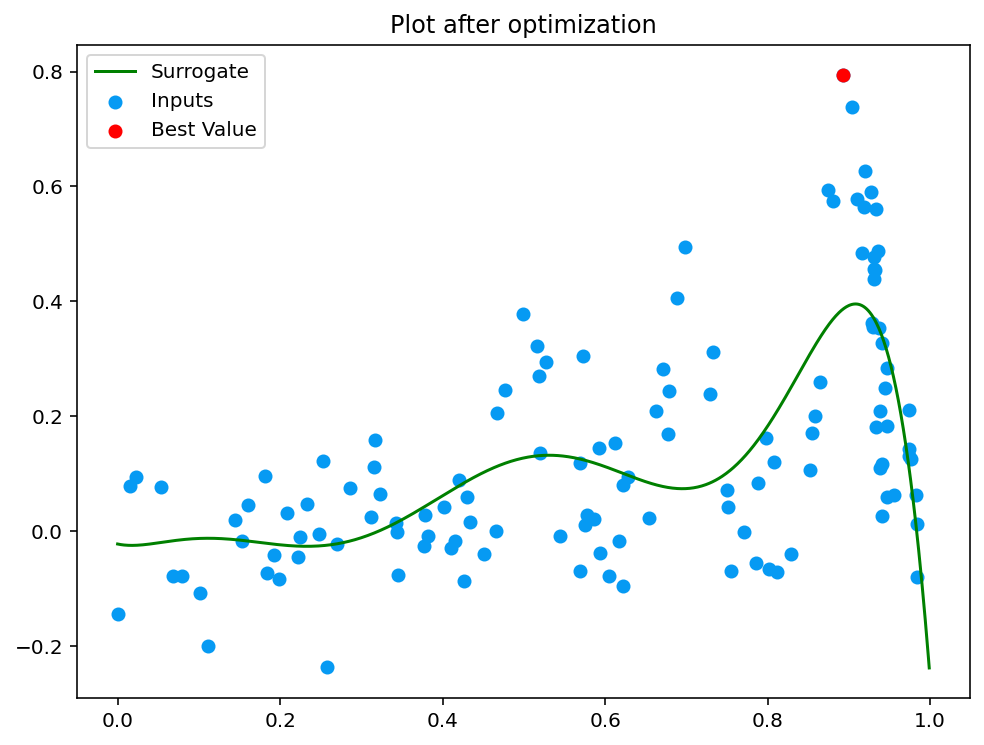

Best Result: x=0.893, y=0.794


In [8]:
noise_level = .1

# objective function
def objective(x, noise=noise_level):
    return (x**2 * np.sin(5 * np.pi * x)**6.0) + np.random.randn() * noise

# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter("ignore")
        return model.predict(X, return_std=True)


# plot helper
def plot(X, y, model, title):
    # scatter plot of inputs and real objective function
    plt.scatter(X, y, c='#069AF3', label="Inputs")
    # line plot of surrogate function across domain
    Xsamples = np.asarray(np.arange(0, 1, 0.001))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples, _ = surrogate(model, Xsamples)
    #plot points from surrogate function
    plt.plot(Xsamples, ysamples, c="green", label="Surrogate")
    #plot the best values of x and y
    best_y = np.argmax(y)
    plt.scatter(X[best_y],y[best_y], color="red", label="Best Value")
    plt.title(title)
    plt.legend()
    # show the plot
    plt.show()


# optimize the acquisition function
def acquisition(X, y, model, low, high, size, verbose=False):
    # random search, generate random samples
    Xsamples = np.random.uniform(low, high, size)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    mu = mu[:, 0]
    # calculate the probability of improvement
    scores = norm.cdf((mu-best) / (std+1E-9))
    # locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix, 0]



def bayes_opt(outer_iters, inner_iters, size, X, y, model, low, high, verbose=False):
    log = {
        'candidate': [],
        'best_x': []
    }
    # perform the optimization process
    for i in range(outer_iters):
        #track the inner_iters best points using the acquisition model to determine where to sample next
        next_points = []
        for j in range(inner_iters):           
            next_points.append(acquisition(X, y, model, low, high, size, verbose))
        x = next_points[np.argmax(np.array(next_points))]  
        # sample the point
        actual = objective(x)       
        if verbose:
            # summarize the finding
            est, _ = surrogate(model, [[x]])
            print('x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
        
        log['candidate'].append(x)
        log['best_x'].append(actual)
        # add the data to the dataset
        X = np.vstack((X, [[x]]))
        y = np.vstack((y, [[actual]]))
        # update the model
        model.fit(X, y)
    return X, y, log  


sampleSize = 100
low = 0
high = 1
# sample the domain sparsely with noise
X = np.random.uniform(low, high, sampleSize)
y = np.asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model, 'Plot before optimization')
# best result
ix = np.argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

final_X, final_y, logs = bayes_opt(25, 50, sampleSize, X, y, model, low, high, True)   #run with outer, inner iterations 
# plot all samples and the final surrogate function
plot(final_X, final_y, model, 'Plot after optimization')
# best result
ix = np.argmax(final_y)
print('Best Result: x=%.3f, y=%.3f' % (final_X[ix], final_y[ix]))

The following cell generates an animated gif of each of the new candidate samples that were returned from the acquisition function. We've included one such animated gif below.

<img src="images/BayesOpt.gif">

You can see that our algorithm did a good job of finding candidate solutions near the global maximum, and improved as the iterations increased.

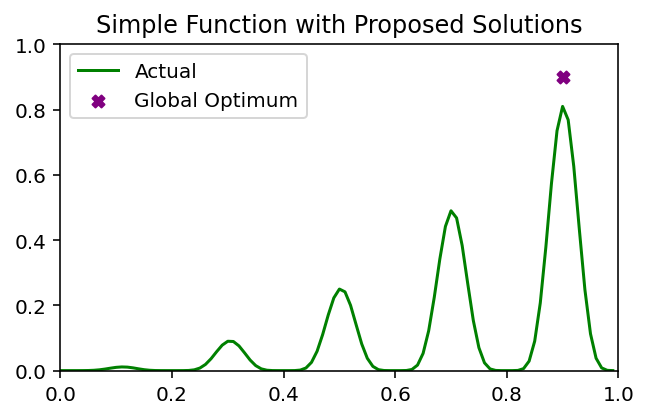

In [8]:
from matplotlib.animation import FuncAnimation
#get the dots provided by the acquisition function
X2 = logs['candidate']
y2 = [objective(x, noise_level) for x in X2]

def animate(i):
    ax.scatter(X2[i], y2[i], c='#069AF3', label=f'Proposed Solution {i}')



fig, ax = plt.subplots(figsize=(5, 3))
ax.set(xlim=(0, 1), ylim=(0, 1))
    
# grid-based sample of the domain [0,1]
X = np.arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
plt.scatter(.9,.9, color="purple", marker='X', label="Global Optimum")
# plot the points without noise
plt.plot(X, y, c="green", label="Actual");

anim = FuncAnimation(fig, animate, interval=100, frames=len(X2)-1)
plt.title('Simple Function with Proposed Solutions');
plt.legend();
# show the plot
plt.show();
anim.save('BayesOpt.gif')

Our from-scratch solution is not the best implementation of this algorithm. But we wanted to include it so that you could really step through each of the pieces. (Note, you can run it with a small sample size and small number of iterations and turn verbose to True to see some output for each iteration.) 

There are several packages that implement Bayes Optimization in a much more efficient way. Let's take a look at two of them: Scikit Optimize and GPyOpt. 

Let's take a look at scikit-learn's function first.

## Bayesian Optimization with Scikit-Optimize

Scikit-learn expects that you are minimizing a function. It also expects that your x value could be a n-dimensional array. Since we're only working with a single dimension here, we need to explicitly use x[0] to get the first item in our array.

In [9]:
noise_level = .1

# objective function
def neg_objective(x, noise=noise_level):
    return -(x[0]**2 * np.sin(5 * np.pi * x[0])**6.0) + np.random.randn() * noise

To function we need to use to run our Bayesian Optimization is <a href="https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html">gp_minimize</a>. There are a lot of parameters you can set on this function, so I encourage you to read the documentation to understand all of them. We are only going to set a few:

* the function to minimize (which should return a scalar (single number) value)
* the dimensions that will be searched
* the acquisition function
    * We can also choose from LCB for lower confidence bount, EI for negative expected improvement, PI for negative probability of improvement or gp_hedge, which probabilistically chooses from one of the first three options at every iteration. This is the default option. But, we'll switch to PI, since that's what we were using above.
* the number of evaluations of the objective function (n_calls)

The function returns an "Optimization Result" object that contains the location of the minimum, the function value at the minimum, and several other values. 

In [10]:
np.random.seed(42) #adding random seed here, too, for the noise factor
#call the optimization.
res = gp_minimize(neg_objective,                  # the function to minimize
                  [(0.0,1.0)],      # the bounds on each dimension of x
                 # acq_func="PI",      # the acquisition function - using PI like above
                  n_calls=15,         # the number of evaluations of the objective function
                  n_random_starts=5,  # the number of random initialization points
                  random_state=42)   # the random seed

"x=%.4f, f(x)=%.4f" % (res.x[0], res.fun)

'x=0.8973, f(x)=-0.9735'

This package also contains some handy plots. First, let's plot convergence. This will tell us how quickly the best value was achieved. In this case, we achieved our best result by the 15th iteration.

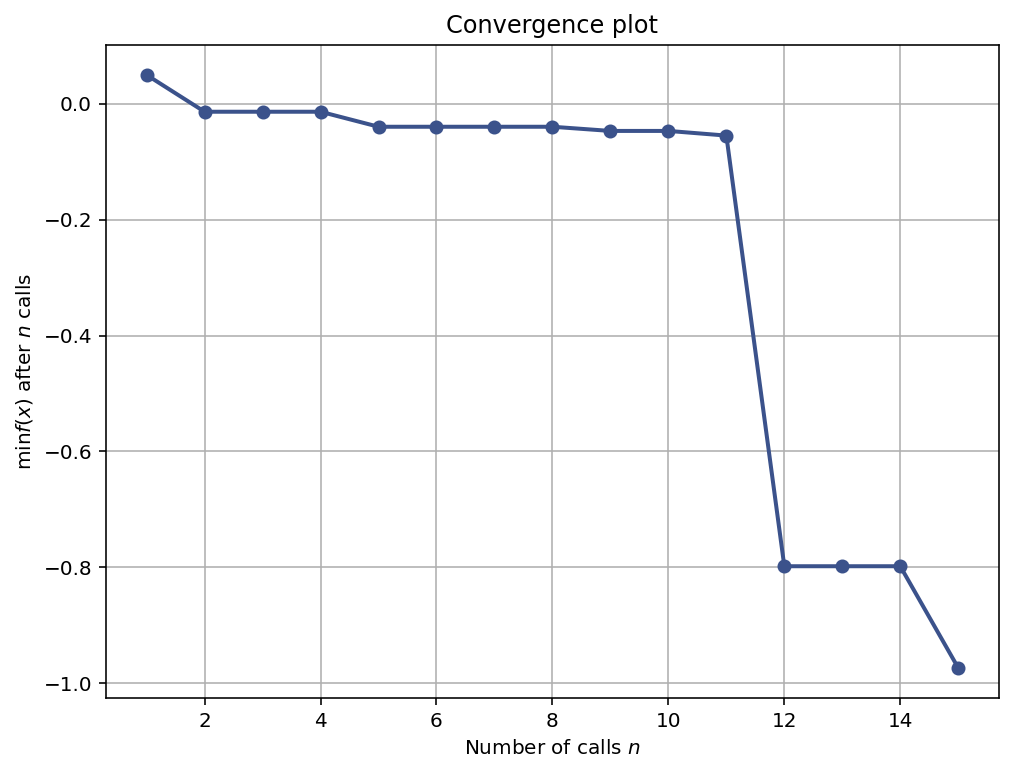

In [11]:
from skopt.plots import plot_convergence
plot_convergence(res);

We can also plot how points are added, and what the next point will be, based off the results of the optimization, using the <a href="https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_gaussian_process.html">plot_gaussian_process function</a>. Note that this function only works with 1-dimensional objective functions.

Let's see what the first 10 iterations of the problem look like. Note that an additional sample point (the red dots) is added with each iteration, and the optimized function line (the green dotted line) begins to resemble the true function line, with points beginning to cluster near the global optimum.

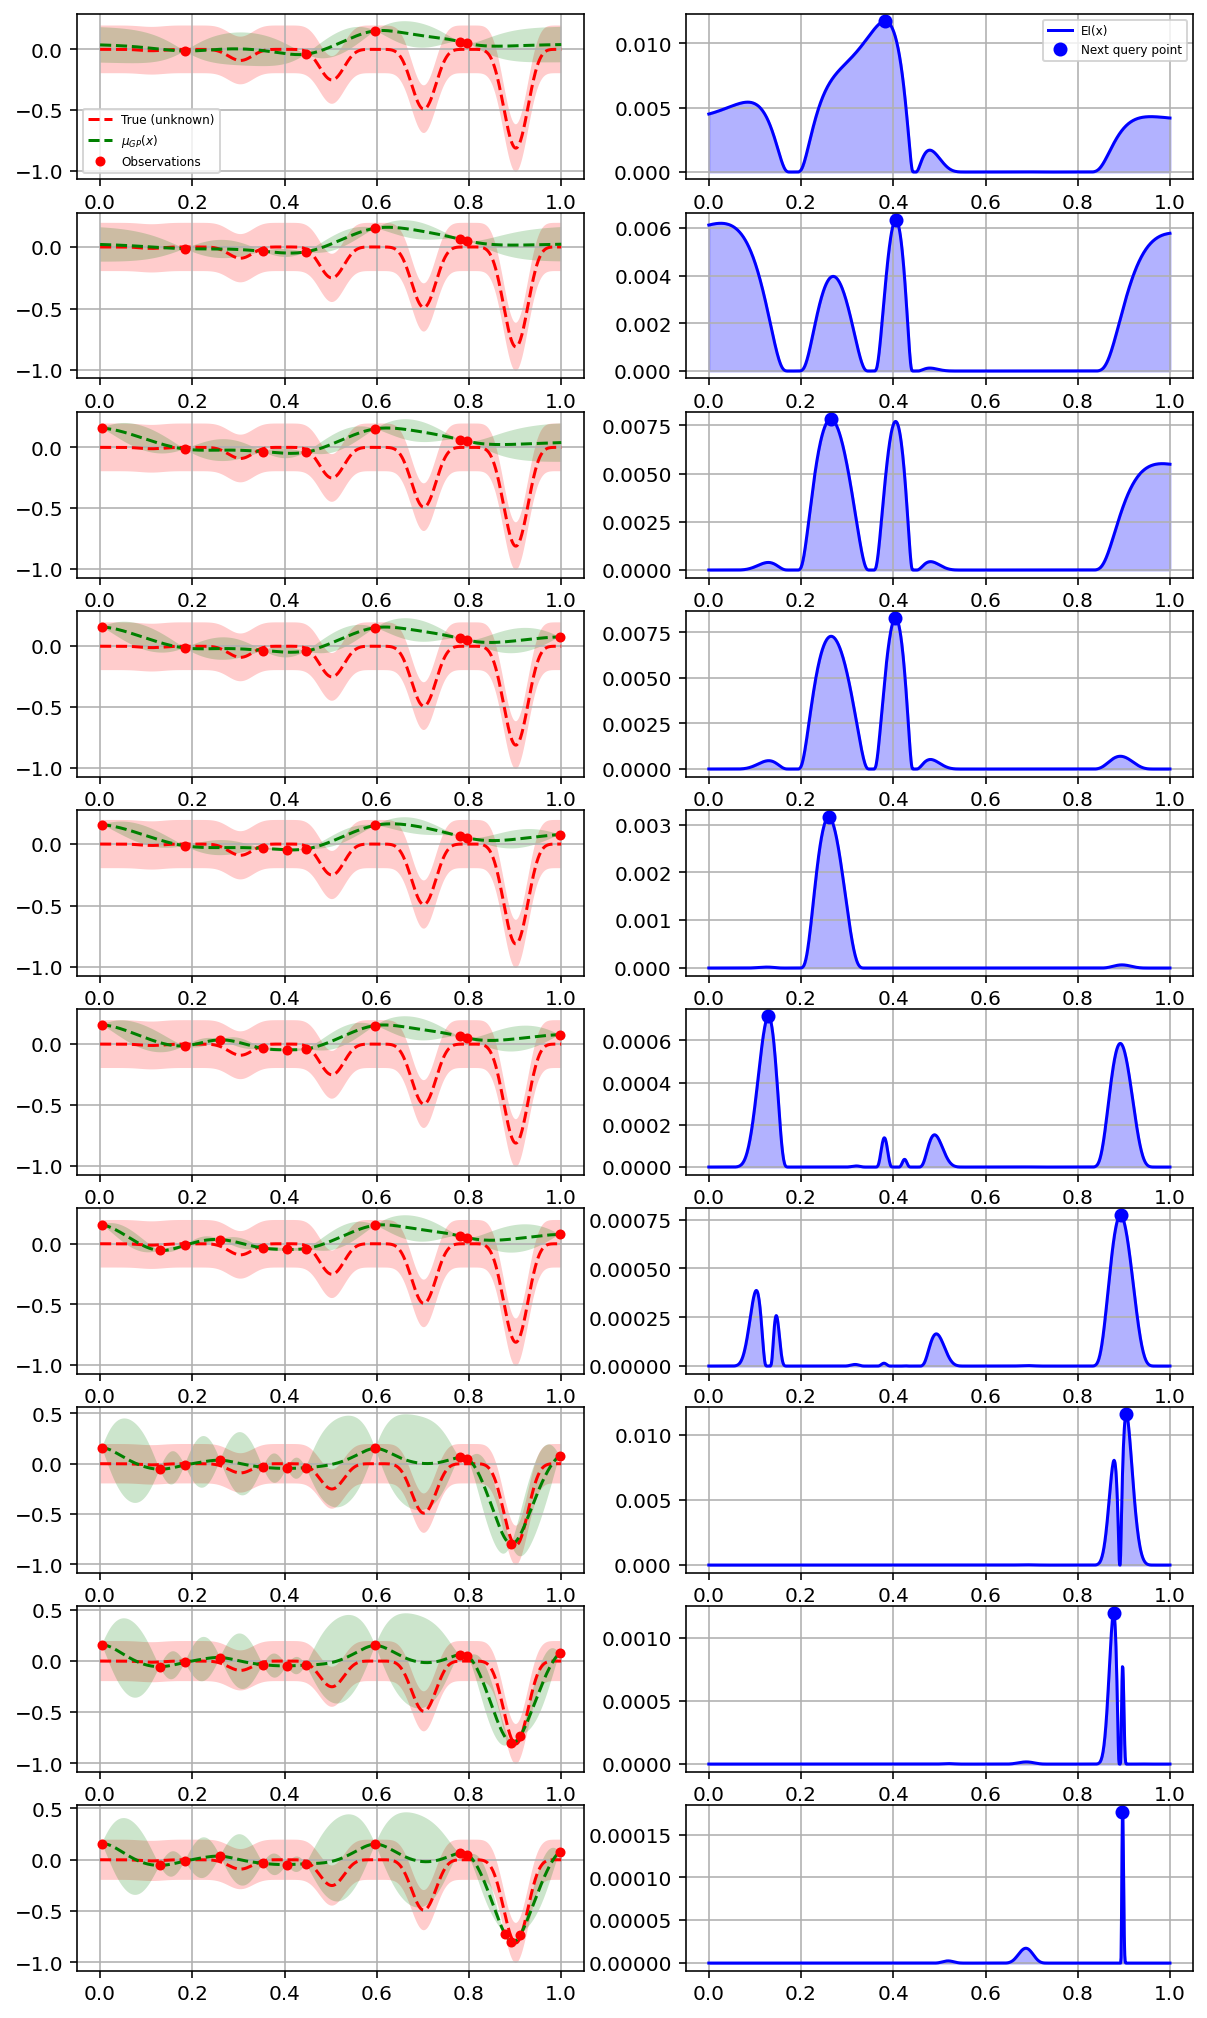

In [12]:
plt.rcParams["figure.figsize"] = (10, 18)


def f_wo_noise(x):
    return neg_objective(x, noise=0)

for n_iter in range(10):
    # Plot true function.
    plt.subplot(10, 2, 2*n_iter+1)

    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False

    ax = plot_gaussian_process(res, n_calls=n_iter,
                               objective=f_wo_noise,
                               noise_level=noise_level,
                               show_legend=show_legend, show_title=False,
                               show_next_point=False, show_acq_func=False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot acquisitionFunction(x)
    plt.subplot(10, 2, 2*n_iter+2)
    ax = plot_gaussian_process(res, n_calls=n_iter,
                               show_legend=show_legend, show_title=False,
                               show_mu=False, show_acq_func=True,
                               show_observations=False,
                               show_next_point=True)
    ax.set_ylabel("")
    ax.set_xlabel("")


plt.show()


We can also view a plot of the final optimized value. We can see that we have a small cluster of samples near the global optimum. We can also see that the algorithm explored some areas that were not local optimum points, too. This can happen while the algorithm is in the exploration phase. If we changed the seed, we'd see different results, with potentially different areas explored.

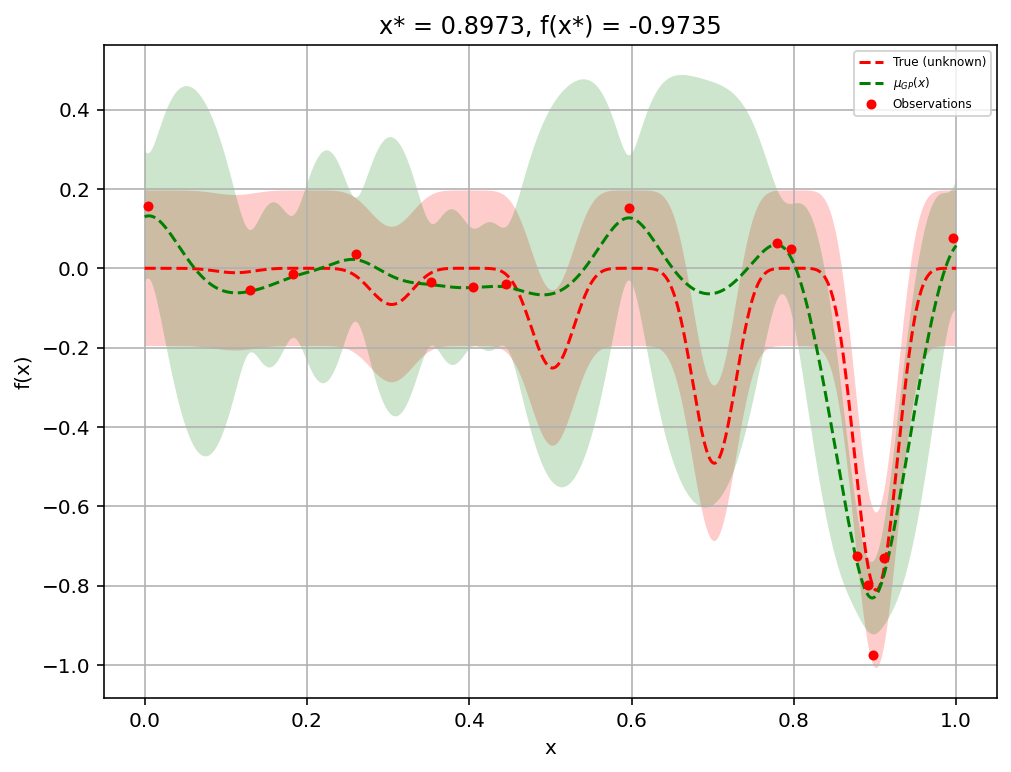

In [13]:
plt.rcParams["figure.figsize"] = (8,6)

# Plot f(x) + contours
_ = plot_gaussian_process(res, objective=f_wo_noise,
                          noise_level=noise_level)

plt.show()

The gp_minimize can handle multi-dimensional functions, as long as what's returned from your objective function is a scalar value. Let's take a look at another one of the test functions for optimization, the Booth function. This function has 2 dimensions (x and y). The function is:

$f(x,y)=(x+2y-7)^2+(2x+y-5)^2$

The bounds for this function are[-10,10] for both x and y, and the global optimum of 0 is at f(1,3). We can plot this function using a contour plot, like in the cell below.



In [14]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import numpy as np

x = np.linspace(-10, 10, 401)     
y = np.linspace(-10, 10, 401)     
X, Y = np.meshgrid(x, y) 
Z = (X + 2*Y-7)**2 + (2*X + Y-5)**2

data = [
    go.Surface( x = X, y = Y, z = Z, colorscale = 'Jet',
        contours=go.surface.Contours(
            z=go.surface.contours.Z(
              show=True,
              usecolormap=True,
              highlightcolor="#42f462",
              project=dict(z=True)
            )
        )
    )
]

layout = go.Layout(title='Booth Function (f(1,3) = 0)',width=600,height=600)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


The global minimum is at zero, so we'll right an objective function that returns the absolute value, because we don't want a negative function result, which we can get with this function. We'll also again add some noise, so the optimization function has to work a bit harder.

In [15]:
#pip install --user --upgrade scikit-learn (have to run this in a .term file and restart kernel if sklearn version below 0.24.2)
import sklearn
print(sklearn.__version__)

0.24.2


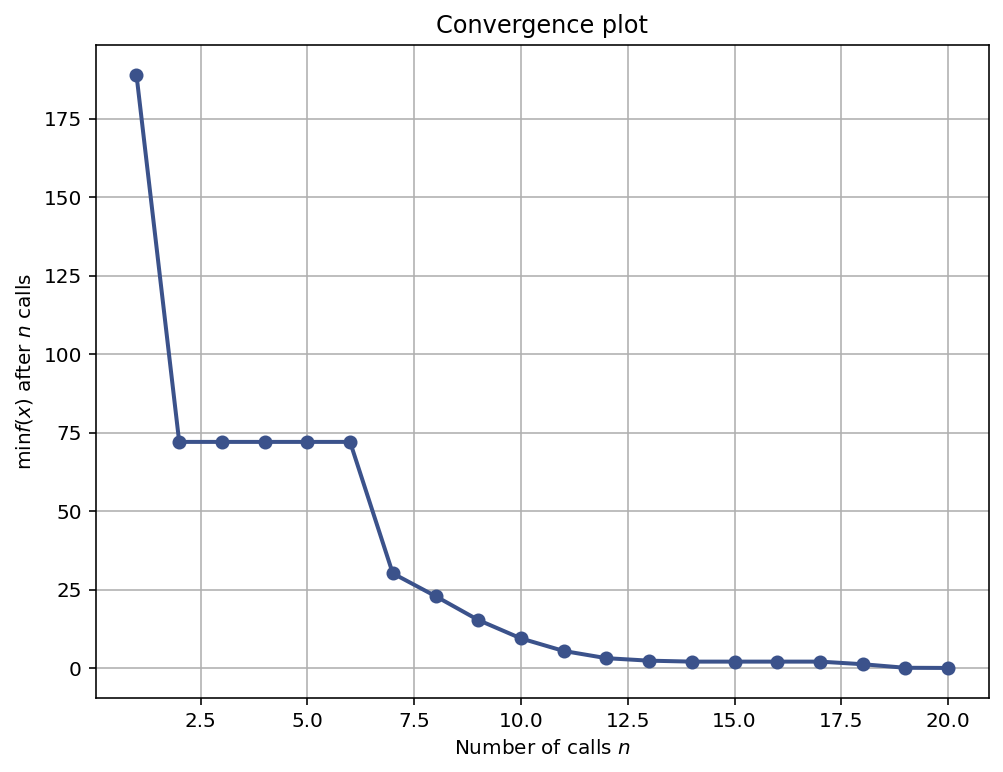

In [16]:
np.random.seed(42)
noise_level = .1

def booth_objective(x , noise=noise_level):
    z = (x[0] + 2*x[1]-7)**2 + (2*x[0] + x[1]-5)**2 + np.random.randn() * noise
    #because we don't want a negative number, return the absolute for optimization
    return abs(z)




#call the optimization.
res = gp_minimize(booth_objective,                  # the function to minimize
                  [(-10.0, 10.0), (-10.0, 10.0)],      # the bounds on each dimension of x
                 acq_func="PI",      # the acquisition function - using PI like above
                  n_calls=20,         # the number of evaluations of the objective function
                  n_random_starts=5,  # the number of random initialization points
                  random_state=42)   # the random seed


"x=%.4f, y=%.4f, f(x)=%.4f" % (res.x[0], res.x[1], res.fun)
plot_convergence(res);